# Variational inference for mean, dispersion, and correlation

Same generative model, but with log-likelihood prior and variational inference.

For now, using ADVI and log-normal likelihoods.

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.moment_helpers import cov2corr

In [3]:
import pymc3 as pm
import pandas as pd
import theano
import theano.tensor as tt

### Scratch/Testing

In [207]:
mean = [1, 1.5]
cov =[[3, 1], [1, 2]]

In [208]:
normal_rvs = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=100000)
lognormal_rvs = np.exp(normal_rvs)



In [209]:
log_mean = np.log(lognormal_rvs.mean(axis=0))
log_disp = np.log(lognormal_rvs.var(axis=0)) - log_mean
corr = cov2corr(np.cov(lognormal_rvs, rowvar=False))

In [210]:
a, b = moment_to_lognorm_params(log_mean, log_disp, corr)

cv [[15.72546039 10.989567  ]
 [10.989567    7.6799394 ]]


In [211]:
a.eval()

array([1.14149769, 1.55473379])

In [212]:
b.eval()

array([[2.81693213, 1.09361493],
       [1.09361493, 2.16101455]])

### Define custom random variables in PyMC3 and scipy

In [5]:
def generalized_binom_coef(x,y):
    
#     if type(x) == int and type(y) == np.ndarray:
#         x = np.full_like(y, x)
#     if type(y) == int and type(y) == np.ndarray:
#         y = np.full_like(x, y)

    return sp.special.gamma(x+1) / (sp.special.gamma(y+1) * sp.special.gamma(x-y+1))

class gen_binom(stats.rv_discrete):
    
    def _pmf(self, k, n, p):
        
        return generalized_binom_coef(n, k) * p ** (k) * (1-p)**(n-k)

In [6]:
import theano.tensor as tt

class Generalized_binomial(pm.Discrete):
    
    def __init__(self, n, p, *args, **kwargs):
        super(Generalized_binomial, self).__init__(*args, **kwargs)
        self.n = n
        self.p = p
        self.mean = n*p
    
    def logp(self, value):
        
        tt.gammaln(self.n+1) - \
        tt.gammaln(value+1) - \
        tt.gammaln(self.n-value+1) + \
        (self.n-value)*tt.log(1-self.p)  + \
        value*tt.log(self.p)

### ADVI

In [21]:
true_log_mean = 1
true_log_disp = 2

In [22]:
N=10000
capture_eff = 0.1

In [23]:
true_mean = np.exp(true_log_mean)
true_disp = np.exp(true_log_disp)
true_sigma_sq = np.log(true_disp/true_mean + 1)
true_mu = true_log_mean - true_sigma_sq/2

In [24]:
z_true = stats.lognorm.rvs(
    s=np.sqrt(true_sigma_sq), 
    scale=np.exp(true_mu),
    size=N)
x_obs = gen_binom().rvs(n=z_true, p=capture_eff)

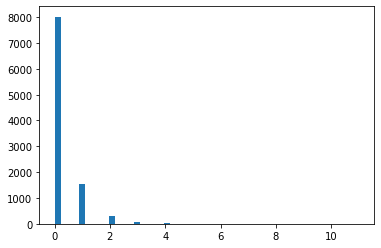

In [25]:
plt.hist(x_obs, bins=50);

In [7]:
import theano.tensor as tt

class Generalized_binomial(pm.Discrete):
    
    def __init__(self, n, p, *args, **kwargs):
        super(Generalized_binomial, self).__init__(*args, **kwargs)
        self.n = n
        self.p = p
        self.mean = n*p
    
    def logp(self, value):
        
        return tt.gammaln(self.n+1) - \
        tt.gammaln(value+1) - \
        tt.gammaln(self.n-value+1) + \
        (self.n-value)*tt.log(1-self.p)  + \
        value*tt.log(self.p)

In [27]:
with pm.Model() as model:
    
    log_mean = pm.Normal('log_mean', mu=true_log_mean, sigma=0.5, testval=true_log_mean)
    log_disp = pm.Normal('log_disp', mu=true_log_disp, sigma=0.5, testval=true_log_disp)
    
    mean = pm.math.exp(log_mean)
    disp = pm.math.exp(log_disp)
    
    sigma_sq = pm.math.log(disp/mean + 1)
    mu = log_mean - sigma_sq/2
    
    z = pm.Normal('z', mu=mu, sigma=pm.math.sqrt(sigma_sq), shape=N)

    x = Generalized_binomial('x', n=pm.math.exp(z), p=capture_eff, observed=x_obs, shape=N)

In [28]:
model.check_test_point()

log_mean       -0.23
log_disp       -0.23
z          -10551.95
x           -7608.15
Name: Log-probability of test_point, dtype: float64

In [29]:
with model:
    mean_field = pm.fit(method='advi')

Average Loss = 7,087.3: 100%|██████████| 10000/10000 [00:30<00:00, 330.92it/s]
Finished [100%]: Average Loss = 7,085.9


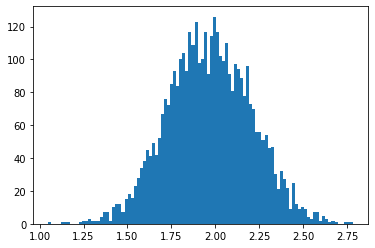

In [30]:
plt.hist(mean_field.sample(4000)['log_disp'], bins=100);

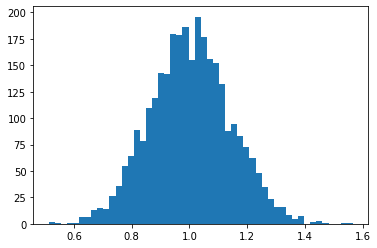

In [32]:
plt.hist(mean_field.sample(3000)['log_mean'], bins=50);

### Auxillary functions to handle multivariate

In [281]:
def expand_upper_triangular(n, packed):
    
    out = tt.ones((n, n), dtype=theano.config.floatX)
    idxs1 = np.triu_indices(n, k=1)
    idxs2 = np.tril_indices(n, k=-1)
    out = tt.set_subtensor(out[tuple(idxs1)], packed)
    out = tt.set_subtensor(out[tuple(idxs2)], packed)
    return out

In [282]:
def cov_from_corr(corr, normal_var):
    """
        Convert a covariance matrix of the exponentiated data
        to a covariance matrix of the original data.
    """

    base_col = tt.reshape(normal_var, (-1, 1))
    base_row = tt.reshape(normal_var, (1, -1))
    base_mtx = tt.sqrt(tt.dot(base_col, base_row))
    return corr*base_mtx

In [283]:
def get_ln_corr(normal_var, normal_cov):
    """
        Convert the correlation in normal space to the log normal space.
        
        corr is the correlation in logged (normal) space.
    """
    
    cv = tt.exp(normal_var)-1
    base_col = tt.reshape(cv, (-1, 1))
    base_row = tt.reshape(cv, (1, -1))
    base_mtx = tt.sqrt(tt.dot(base_col, base_row))
    ln_corr = (tt.exp(normal_cov)-1) / base_mtx
    
    return ln_corr

In [284]:
def moment_to_params(log_mean, log_disp, corr):
    """
        Convert a vector of log means, log indices of dispersion, and a correlation
        matrix to the parameters of the lognormal distribution, i.e. the
        parameters of the underlying normal distribution.
        
        corr is the correlation in the logged (normal) space.
    """
    
    mean = tt.exp(log_mean)
    disp = tt.exp(log_disp)
    var = tt.exp(log_disp + log_mean)
    normal_var = tt.log(1+var/mean**2)
    
    mu = log_mean - tt.log(disp/mean + 1)/2
    sigma = cov_from_corr(corr, normal_var)
    
    ln_corr = get_ln_corr(normal_var, sigma)
    return mu, sigma, ln_corr
    
    

### Multivariate case

In [285]:
N = 1000
d = 3
p=0.1

In [288]:
random_mtx = np.random.normal(size=(d,d))
cov_mtx = random_mtx.T@random_mtx
var_mv = np.diag(cov_mtx)
log_mean_mv = np.random.normal(size=d)
log_disp_mv = np.log(var_mv)-log_mean_mv
corr_mv = cov2corr(cov_mtx)
corr_mv_vals = corr_mv[np.triu_indices(d, k=1)]
print('log-mean', log_mean_mv)
print('log-disp', log_disp_mv)
print('corr\n', corr_mv)
print('corr values', corr_mv_vals)

mu_mv, sigma_mv, ln_corr = moment_to_params(
    log_mean_mv,
    log_disp_mv,
    corr_mv)
mu_mv, sigma_mv, ln_corr = mu_mv.eval(), sigma_mv.eval(), ln_corr.eval()
print('ln_corr\n', ln_corr)


log-mean [ 1.97440011 -1.22274507 -0.33575851]
log-disp [-0.54428266  2.1903463   0.42418657]
corr
 [[ 1.         -0.10950055  0.26672712]
 [-0.10950055  1.         -0.77225065]
 [ 0.26672712 -0.77225065  1.        ]]
corr values [-0.10950055  0.26672712 -0.77225065]
ln_corr
 [[ 1.         -0.03517256  0.1991038 ]
 [-0.03517256  1.         -0.09732165]
 [ 0.1991038  -0.09732165  1.        ]]


In [312]:
sigma_mv

array([[ 0.07748466, -0.05657835,  0.07939973],
       [-0.05657835,  3.44549971, -1.53295126],
       [ 0.07939973, -1.53295126,  1.14363625]])

In [313]:
with pm.Model() as model:
    
    log_mean = pm.Normal(
        'log_mean', 
        mu=log_mean_mv, 
        sigma=0.2, 
        shape=d,
        testval=log_mean_mv)
    
    tt.printing.Print('temp')(log_disp)
    
    log_disp = pm.Normal(
        'log_disp', 
        mu=log_disp_mv,
        sigma=0.2,
        shape=d,
        testval=log_disp_mv)
    
    tt.printing.Print('logdisp')(log_disp)
    corr = pm.LKJCorr(
        'corr',
        eta=0.1,
        n=d,
        testval=corr_mv_vals)
    
    tt.printing.Print('corr')(corr)
    
    corr_mat = expand_upper_triangular(n=d, packed=corr)
    
    mu, sigma, adjusted_corr = moment_to_lognorm_params(log_mean, log_disp, corr_mat)
    
    #ln_corr = pm.Deterministic('ln_corr', adjusted_corr)
    
    z = pm.MvNormal('z', mu=mu, cov=sigma, shape=(N,d), testval=mu)

    x = Generalized_binomial('x', n=pm.math.exp(z), p=p, observed=x_obs, shape=(N,d))
    
    

temp __str__ = [-0.54428266  2.1903463   0.42418657]
logdisp __str__ = [-0.54428266  2.1903463   0.42418657]
corr __str__ = [-0.10950055  0.26672712 -0.77225065]


In [314]:
model.check_test_point()

log_mean              2.07
log_disp              2.07
corr_interval__      13.05
z                 -1660.52
x                 -1617.91
Name: Log-probability of test_point, dtype: float64

In [316]:
with model:
    model = pm.sample(100)
    #mean_field = pm.fit(method='advi')

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidim

ValueError: Not enough samples to build a trace.